## 14.2 自己速度積分モデル

自己運動の速度を積分して自己位置を推定させるタスクをRNNに学習させると、中間層にグリッド細胞のような発火パターンが生まれたという論文が2018年に2本出された。  

> C. Cueva, X. Wei. "Emergence of grid-like representations by training recurrent neural networks to perform spatial localization". *ICLR.* (2018). ([arxiv](https://arxiv.org/abs/1803.07770))

グリッド状の場所受容野がRNN(recurrent neural network)で形成されることを示す最初の論文。モデルは次図のような感じ。このモデルにおいて、次のような場所受容野が形成された。グリッド細胞の発達も一致することも示された。

> A. Banino, et al. "Vector-based navigation using grid-like representations in artificial agents". *Nat.* **557**(7705), 429–433 (2018). ([pdf](https://deepmind.com/documents/201/Vector-based%20Navigation%20using%20Grid-like%20Representations%20in%20Artificial%20Agents.pdf))

上の論文よりも出たのは少し遅いが、ほぼ同時期。強化学習のタスクで良い成績を出したことが注目されていたが、神経科学的にこの論文の注目すべき点はそこではない。  

タスクは(Cueva et al. 2018)とほぼ同じ。ただし、出力が自己位置のスカラー値ではなく、どの場所細胞の受容野に近いかの確率と、頭はどの方向を向いているかの確率となっている。どちらも一様分布から生成している。  

このモデルは3層からなり、再帰層(LSTM)、線形層、出力層から構成される。学習後の線形層には場所受容野が獲得されていた。  

さらにこのモデルが学習したグリッド細胞の特性は一致していた。

グリッド細胞の発火の方向が壁面から少しずれていることは謎であったが、この実験から、そうであることが最適であるということが分かった。つまり、壁面からずれていることで、格子パターンが空間全体を覆うことができ、一様な場所受容野の形成に役立っているといえる。  

もう1つ、この論文を読んで面白いと思ったのは、ニューラルネットワークを用いて脳の仕組みを明らかにすることについてのDeepMindの考えを知ることができたことである。"Supplementary Discussion:Relationship to previous models of grid cells"(pp.71)より一部引用。

> "It is worth noting that our experiments were not designed to provide insights into the development of grid cells in the brain — due to the limitations of the training algorithm used (i.e. backpropagation) in terms of biological plausibiliy. More generally, however, our findings accord with the perspective that the internal representations of individual brain regions such as the entorhinal cortex arise as a consequence of optimizing for specific ethologically important objective functions (e.g. path integration) — providing a parallel to the optimization process in neural networks."
>

日本語でまとめると、「ニューラルネットワークは誤差逆伝搬法などの学習方法の制約により、生物的な発達まで完全にシミュレーションはできない。しかし、脳の神経表現が生物学的に重要な目的関数（経路積分など）の最適化として生じるということは、ニューラルネットワークを通した実験で知ることができる。」ということ。ニューラルネットワークで脳の仕組みを知ることについては否定的な声もあるが、様々な論文を読んだ感想、および実際に研究している感想は、「ニューラルネットワークを用いれば、神経表現の"How(どのように獲得されたか)"は十分に分からなくても"Why(なぜそのような発火パターンなのか)"は知ることができる」というものである。当然、写像として定義できないことに関してはニューラルネットワークで考えることは難しい。しかし、写像で定義できるものに関しては、ニューラルネットワークは脳の仕組みを知るための強力なツールであると思う。  

## 14.2.1 学習データの生成

([Raudies & Hasselmo, PLoS Comput Biol. 2012](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553)) に従って作成。

### ラットの行動軌跡

In [1]:
using PyPlot
using Random
using Distributions

using Base: @kwdef
using Parameters: @unpack # or using UnPack
using ProgressMeter

In [2]:
ROOM_LEN = 2.2 # Width and height of environment (meters)
PERIMETER_DIST = 0.03 # Perimeter region distance to walls (meters)
SIGMA_V = 0.13 # Forward velocity Rayleigh distribution scale (m/sec)
MU_PHI = 0.0  # Rotation velocity Gaussian distribution mean (rad/sec)
SIGMA_PHI = (330 / 360) * 2pi # Rotation velocity Gaussian distribution standard deviation (rad/sec)
RHO_RH = 0.25 # Velocity reduction factor when located in the perimeter

DELTA_T = 0.02 # Simulation-step time increment (seconds)

NUM_PLACE_CELL = 256 # Number of place cells
SIGMA_C = 0.01 # Place cell standard deviation parameter (meters)

0.01

In [3]:
wrap(x) = mod(x, 2pi) # limit 0~2pi angle

wrap (generic function with 1 method)

Juliaの余りの関数は `rem(x, y)` と `mod(x, y)`がある。Juliaの`x % y`は`rem`と同じだが、Pythonの場合は`mod`と同じなので、注意。

In [4]:
println("% : ", -1 % 2, ", rem : ", rem(-1, 2), ", mod : ", mod(-1, 2))

% : -1, rem : -1, mod : 1


In [5]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngle(pos, theta)
    if pos[1] < PERIMETER_DIST
        dist_fm_wall = pos[1]
        angle_fm_wall = theta + pi
    elseif pos[2] < PERIMETER_DIST
        dist_fm_wall = pos[2]
        angle_fm_wall = theta + 1.5pi
    elseif pos[1] > ROOM_LEN - PERIMETER_DIST
        dist_fm_wall = ROOM_LEN - pos[1]
        angle_fm_wall = theta
    elseif pos[2] > ROOM_LEN - PERIMETER_DIST
        dist_fm_wall = ROOM_LEN - pos[2]
        angle_fm_wall = theta + 0.5pi
    else
        dist_fm_wall = 3.0
        angle_fm_wall = 0.0
    end

    angle_fm_wall = wrap(angle_fm_wall)

    return dist_fm_wall, angle_fm_wall
end

minDistAngle (generic function with 1 method)

In [11]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngleSquare(pos, θ)
    if pos[1] < PERIMETER_DIST
        dWall, aWall = pos[1], θ + π
    elseif pos[2] < PERIMETER_DIST
        dWall, aWall = pos[2], θ + 1.5π
    elseif pos[1] > ROOM_LEN - PERIMETER_DIST
        dWall, aWall = ROOM_LEN - pos[1], θ
    elseif pos[2] > ROOM_LEN - PERIMETER_DIST
        dWall, aWall = ROOM_LEN - pos[2], θ + 0.5π
    else
        dWall, aWall = 3.0, 0.0
    end
    aWall = wrap(aWall)
    return dWall, aWall
end;

In [69]:
function trajectory(num_steps)
    # store arrays
    positions = zeros(num_steps, 2)
    velocities = zeros(num_steps, 2)
    thetas = zeros(num_steps) # head direction
    speeds = zeros(num_steps) # Forward speed
    omegas = zeros(num_steps) # rotation velocity

    speed = 0.
    omega = 0.  # angular velocity
    init_pos = clamp.(rand(2) * ROOM_LEN, -0.1, ROOM_LEN-0.1)
    pos = init_pos
    init_theta = rand() * 2pi  # angular pos
    theta = init_theta
    
    # Iteration of trajectory
    for i in 1:num_steps
        dist_fm_wall, angle_fm_wall = minDistAngle(pos, theta)

        if (dist_fm_wall < PERIMETER_DIST) && (0 < angle_fm_wall < pi)
            # turn
            theta = wrap(sign(angle_fm_wall) * (pi - abs(angle_fm_wall)) + MU_PHI + randn()*SIGMA_PHI)
            # slow down
            speed -= speed * RHO_RH
        else
            speed = rand(Rayleigh(SIGMA_V))
            omega = MU_PHI + randn()*SIGMA_PHI
            theta = wrap(theta + omega * DELTA_T)
        end
        
        velocity = speed * [sin(theta), cos(theta)]

        # update pos, angle
        pos += velocity * DELTA_T

        # store in array
        positions[i, :] = pos
        velocities[i, :] = velocity
        thetas[i] = theta
        speeds[i] = speed
        omegas[i] = omega
    end
        
    # inputs
    rot_vel = [sin.(omegas), cos.(omegas)]'
    forward_speed = speeds
    
    return init_pos, init_theta, positions, velocities, thetas, rot_vel, forward_speed
end

trajectory (generic function with 1 method)

In [72]:
num_timesteps = 100000
init_pos, init_theta, positions, velocities, thetas, rot_vel, forward_speed  =  trajectory(num_timesteps)

size(positions)
#mu_c = generate_place_cells(True)

(100000, 2)

In [50]:
positions[1,:] == init_pos + forward_speed[1] * [sin(thetas[1]), cos(thetas[1])] * DELTA_T

false

In [9]:
forward_speed[1]

0.20414355015011545

黒点から始まり、赤点に終わる。

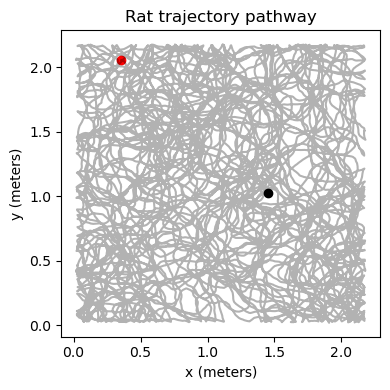

In [73]:
figure(figsize=(4, 4))
title("Rat trajectory pathway")
xlabel("x (meters)"); ylabel("y (meters)")
#xlim((0, ROOM_LEN+0.01)); ylim((0, ROOM_LEN))
plot(positions[1, 1], positions[1, 2], "ko")
plot(positions[end, 1], positions[end, 2], "ro")
plot(positions[:, 1], positions[:, 2], color="k", alpha=0.3)
tight_layout()

In [11]:
size(thetas)

(20000,)

In [12]:
size(forward_speed)

(20000,)

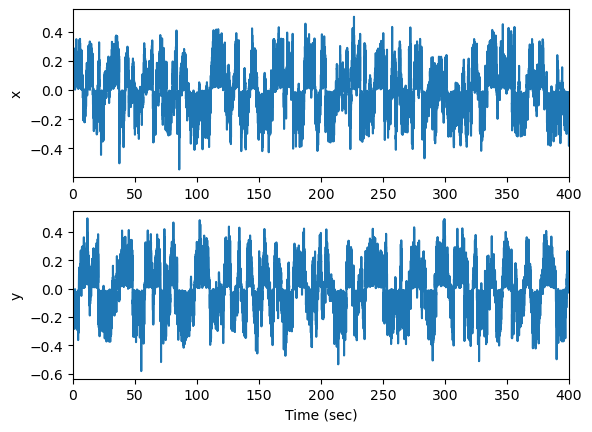

(0.0, 400.0)

In [13]:
tsteps = (1:num_timesteps)*DELTA_T
subplot(2,1,1)
plot(tsteps, velocities[:, 1])
ylabel("x")
xlim(0, tsteps[end])
subplot(2,1,2)
plot(tsteps, velocities[:, 2])
ylabel("y"); xlabel("Time (sec)")
xlim(0, tsteps[end])

## RNN model

In [14]:
f(x) = tanh(x)
df(x) = 1 - tanh(x)^2

df (generic function with 1 method)

In [15]:
@kwdef struct RNNParameter{FT}
    dt::FT = 1 # time step (ms)
    τ::FT = 10 # time constant (ms)
    α::FT = dt / τ 
    η::FT = 1e-2 # learning rate
end

In [16]:
@kwdef mutable struct RNN{FT}
    param::RNNParameter = RNNParameter{FT}()
    
    n_in::UInt32 # number of input units
    n_rec::UInt32 # number of recurrent units
    n_out::UInt32 # number of output units
    
    # weights
    w_in::Array{FT} = 0.1*(rand(n_in, n_rec) .- 1)
    w_in_pos::Array{FT} = 0.1*(rand(n_out, n_rec) .- 1)
    w_rec::Array{FT} = 1.5*randn(n_rec, n_rec)/sqrt(n_rec)
    w_out::Array{FT} = 0.1*(2*rand(n_rec, n_out) .- 1)/sqrt(n_rec)
    bias::Array{FT} = zeros(1, n_rec)
    
    # changes to weights
    dw_in::Array{FT} = zero(w_in)
    dw_in_pos::Array{FT} = zero(w_in_pos)
    dw_rec::Array{FT} = zero(w_rec)
    dw_out::Array{FT} = zero(w_out)
    dbias::Array{FT} = zero(bias)
end

In [39]:
function update!(variable::RNN, param::RNNParameter, x::Array, y::Array, init_state::Array, training::Bool)
    @unpack n_in, n_rec, n_out, w_in, w_in_pos, w_rec, w_out, bias, dw_in, dw_in_pos, dw_rec, dw_out, dbias = variable 
    @unpack dt, τ, α, η = param

    n_batch, t_max, _ = size(x)

    u = zeros(n_batch, t_max, n_rec) # input (feedforward + recurrent)
    h = zeros(n_batch, t_max, n_rec)  # time-dependent RNN activity vector
    h[:, 1, :] = init_state * w_in_pos  # initial state

    ŷ = zeros(n_batch, t_max, n_out)  # RNN output
    error = zeros(n_batch, t_max, n_out)  # readout error

    for t in 1:t_max-1
        u[:, t+1, :] = h[:, t, :] * w_rec + x[:, t+1, :] * w_in .+ bias + randn(n_batch, n_rec) * 1e-2
        h[:, t+1, :] = h[:, t, :] + α * (-h[:, t, :] + f.(u[:, t+1, :]))
        ŷ[:, t+1, :] = h[:, t+1, :] * w_out 
        error[:, t+1, :] = y[:, t+1, :] - ŷ[:, t+1, :]  # readout error
    end
    
    
    # backward
    if training 
        z = zero(h)
        z[:, end, :] = error[:, end, :] * w_out' 

        for t in t_max:-1:1
            zu = z[:, t, :] .* df.(u[:, t, :])
            if t ≥ 2
                z[:, t-1, :] = z[:, t, :] * (1 - α) + error[:, t, :] * w_out' + zu * w_rec * α
                dw_rec[:, :] += h[:, t-1, :]' * zu
            end

            # Updates  Δweights:
            dw_out[:, :] += h[:, t, :]' * error[:, t, :]
            dw_in[:, :]  += x[:, t, :]' * zu
            dbias[:, :] .+= sum(zu)
            
            if t == 1
                dw_in_pos[:, :] = init_state' * zu
            end
        end
        
        # update weights
        w_out[:, :] = (1-1e-4)*w_out[:, :] + clamp.(η/(t_max*n_batch) * dw_out, -1e-2, 1e-2)
        w_rec[:, :] = (1-1e-4)*w_rec[:, :] + clamp.(η/(t_max*n_batch) * α * dw_rec, -1e-2, 1e-2)
        w_in[:, :]  += clamp.(η/(t_max*n_batch) * α * dw_in, -1e-2, 1e-2)
        w_in_pos[:, :]  += clamp.(η/n_batch * α * dw_in_pos, -1e-2, 1e-2)
        bias[:, :]  += clamp.(η/(t_max*n_batch) * α * dbias, -1e-2, 1e-2)
        
        # reset
        dw_in[:, :]  = zero(w_in)
        dw_in_pos[:, :]  = zero(w_in_pos)
        dw_rec[:, :] = zero(w_rec)
        dw_out[:, :] = zero(w_out)
        dbias[:, :]  = zero(bias)
    end

    return error, ŷ, h
end

update! (generic function with 1 method)

## データセットの生成

In [35]:
nt = 100  # number of timesteps in one period
n_data = 20000 # number of datasets
n_batch = 20 # batch size
n_iter = Int(n_data / n_batch) # number of iterations in one epoch
n_epoch = 50 # number of epoch

n_in = 2 # number of inputs
n_out = 2 # number of outputs

init_pos_states = zeros(n_data, n_out)
target_pos = zeros(n_data, nt, n_out)
input_vel = zeros(n_data, nt, n_in)
#tsteps = 0:nt-1　# array of time steps
#y = zeros(n_batch, nt, n_out) # target array

for i in 1:n_data
    init_pos, _, positions, velocities, thetas, _, forward_speed  =  trajectory(nt)
    init_pos_states[i, :] = init_pos
    target_pos[i, :, :] = positions
    input_vel[i, :, :] = velocities
    #input_vel[i, :, 1] = forward_speed
    #input_vel[i, :, 2] = thetas
end

In [36]:
rnn = RNN{Float32}(n_in=n_in, n_rec=100, n_out=n_out)

RNN{Float32}(RNNParameter{Float32}(1.0f0, 10.0f0, 0.1f0, 0.01f0), 0x00000002, 0x00000064, 0x00000002, Float32[-0.08821082 -0.08222339 … -0.030185988 -0.06459659; -0.0002401762 -0.052213997 … -0.085990205 -0.044276245], Float32[-0.041896507 -0.024656205 … -0.04107195 -0.07226; -0.047625184 -0.010071095 … -0.004556209 -0.025351837], Float32[-0.04149108 0.06768774 … 0.06520658 -0.0046281177; -0.019517537 -0.37739837 … -0.028190548 0.10089775; … ; 0.0417727 0.04440057 … -0.02872693 0.088635825; -0.21821253 0.0136082675 … 0.08089772 -0.22119096], Float32[0.0060535064 -0.0055856584; -0.0022381423 0.0026251073; … ; -0.0018827434 0.0029900766; 0.008486797 0.0024125257], Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0])

In [37]:
error_arr = zeros(Float32, n_epoch) # memory array of each epoch error

50-element Array{Float32,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [40]:
@showprogress "Training..." for e in 1:n_epoch
    for i in 1:n_iter
        bidx = 1+n_batch*(i-1) # begin index
        eidx = n_batch*i # end index
        error, ŷ, h = update!(rnn, rnn.param, input_vel[bidx:eidx, :, :], target_pos[bidx:eidx, :, :], init_pos_states[bidx:eidx, :], true)
        error_arr[e] += sum(error .^ 2) / (n_iter*n_batch)
    end
    println("Epoch", e, " : ", error_arr[e])
end

Training...  2%|█                                       |  ETA: 0:31:39

Epoch1 : 24.036005


Training...  4%|██                                      |  ETA: 0:30:18

Epoch2 : 2.3545353


Training...  6%|███                                     |  ETA: 0:29:20

Epoch3 : 0.97560936


Training...  8%|████                                    |  ETA: 0:28:27

Epoch4 : 0.85019934


Training... 10%|█████                                   |  ETA: 0:27:47

Epoch5 : 0.71171737


Training... 12%|█████                                   |  ETA: 0:27:01

Epoch6 : 0.57733124


Training... 14%|██████                                  |  ETA: 0:26:17

Epoch7 : 0.495908


Training... 16%|███████                                 |  ETA: 0:25:34

Epoch8 : 0.4474715


Training... 18%|████████                                |  ETA: 0:24:53

Epoch9 : 0.42054257


Training... 20%|█████████                               |  ETA: 0:24:14

Epoch10 : 0.39734682


Training... 22%|█████████                               |  ETA: 0:23:35

Epoch11 : 0.37983912


Training... 24%|██████████                              |  ETA: 0:22:57

Epoch12 : 0.36503333


Training... 26%|███████████                             |  ETA: 0:22:17

Epoch13 : 0.35317537


Training... 28%|████████████                            |  ETA: 0:21:36

Epoch14 : 0.34287125


Training... 30%|█████████████                           |  ETA: 0:20:56

Epoch15 : 0.33279887


Epoch16 : 0.3253429


Training... 34%|██████████████                          |  ETA: 0:19:39

Epoch17 : 0.31897002


Training... 36%|███████████████                         |  ETA: 0:19:01

Epoch18 : 0.31552458


Training... 38%|████████████████                        |  ETA: 0:18:23

Epoch19 : 0.3099709


Training... 40%|█████████████████                       |  ETA: 0:17:45

Epoch20 : 0.30538034


Training... 42%|█████████████████                       |  ETA: 0:17:08

Epoch21 : 0.30338892


Training... 44%|██████████████████                      |  ETA: 0:16:31

Epoch22 : 0.30057088


Training... 46%|███████████████████                     |  ETA: 0:15:55

Epoch23 : 0.29781476


Training... 48%|████████████████████                    |  ETA: 0:15:18

Epoch24 : 0.29560742


Training... 50%|█████████████████████                   |  ETA: 0:14:42

Epoch25 : 0.29385263


Training... 52%|█████████████████████                   |  ETA: 0:14:06

Epoch26 : 0.29274064


Training... 54%|██████████████████████                  |  ETA: 0:13:30

Epoch27 : 0.29105407


Training... 56%|███████████████████████                 |  ETA: 0:12:54

Epoch28 : 0.2898401


Training... 58%|████████████████████████                |  ETA: 0:12:18

Epoch29 : 0.2890768


Training... 60%|█████████████████████████               |  ETA: 0:11:43

Epoch30 : 0.2875405


Training... 62%|█████████████████████████               |  ETA: 0:11:07

Epoch31 : 0.28672838


Training... 64%|██████████████████████████              |  ETA: 0:10:31

Epoch32 : 0.285986


Training... 66%|███████████████████████████             |  ETA: 0:09:56

Epoch33 : 0.2855149


Training... 68%|████████████████████████████            |  ETA: 0:09:21

Epoch34 : 0.28404516


Training... 70%|█████████████████████████████           |  ETA: 0:08:45

Epoch35 : 0.28424773


Training... 72%|█████████████████████████████           |  ETA: 0:08:10

Epoch36 : 0.28453335


Training... 74%|██████████████████████████████          |  ETA: 0:07:35

Epoch37 : 0.2825097


Training... 76%|███████████████████████████████         |  ETA: 0:07:00

Epoch38 : 0.28252247


Training... 78%|████████████████████████████████        |  ETA: 0:06:25

Epoch39 : 0.2817624


Training... 80%|█████████████████████████████████       |  ETA: 0:05:50

Epoch40 : 0.28135148


Training... 82%|█████████████████████████████████       |  ETA: 0:05:15

Epoch41 : 0.28021112


Training... 84%|██████████████████████████████████      |  ETA: 0:04:40

Epoch42 : 0.28060275


Training... 86%|███████████████████████████████████     |  ETA: 0:04:04

Epoch43 : 0.2790744


Training... 88%|████████████████████████████████████    |  ETA: 0:03:29

Epoch44 : 0.2783983


Training... 90%|█████████████████████████████████████   |  ETA: 0:02:55

Epoch45 : 0.27906257


Training... 92%|█████████████████████████████████████   |  ETA: 0:02:20

Epoch46 : 0.2776396


Epoch47 : 0.27819392


Training... 96%|███████████████████████████████████████ |  ETA: 0:01:10

Epoch48 : 0.27732563


Training... 98%|████████████████████████████████████████|  ETA: 0:00:35

Epoch49 : 0.27727783


Training...100%|████████████████████████████████████████| Time: 0:29:02


Epoch50 : 0.27649963


In [41]:
error_arr

50-element Array{Float32,1}:
 24.036005
  2.3545353
  0.97560936
  0.85019934
  0.71171737
  0.57733124
  0.495908
  0.4474715
  0.42054257
  0.39734682
  0.37983912
  0.36503333
  0.35317537
  ⋮
  0.2817624
  0.28135148
  0.28021112
  0.28060275
  0.2790744
  0.2783983
  0.27906257
  0.2776396
  0.27819392
  0.27732563
  0.27727783
  0.27649963

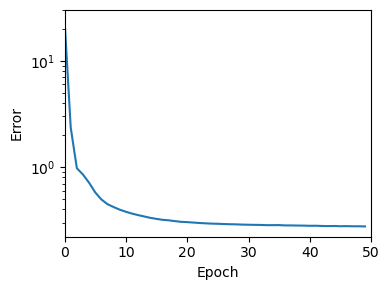

In [42]:
figure(figsize=(4,3))
semilogy(error_arr)
ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

## 確認

In [43]:
add_dim(x::Array) = reshape(x, (1, size(x)...))

add_dim (generic function with 1 method)

In [44]:
nt_test = 500
init_pos, _, positions, velocities, thetas, _, forward_speed  =  trajectory(nt_test)
error, ŷ, h = update!(rnn, rnn.param, add_dim(velocities), add_dim(positions), add_dim(init_pos), false)
println("Error : ", sum(error.^2)/nt_test)

Error : 0.02361473659021657


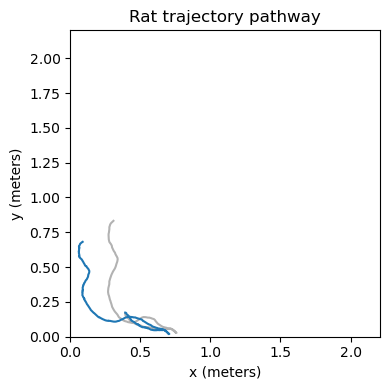

In [45]:
figure(figsize=(4, 4))
title("Rat trajectory pathway")
xlabel("x (meters)"); ylabel("y (meters)")
xlim((0, ROOM_LEN+0.01)); ylim((0, ROOM_LEN))
plot(positions[2:end, 1], positions[2:end, 2], color="k", alpha=0.3)
plot(ŷ[1, 2:end, 1], ŷ[1, 2:end, 2])
tight_layout()

In [27]:
using StatsBase

In [30]:
hstep = ROOM_LEN / 10

0.22000000000000003

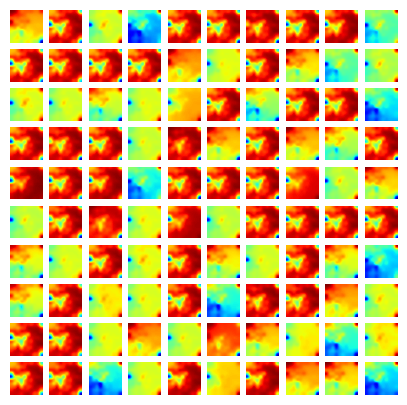

In [31]:
figure(figsize=(5,5))

occup_hist = fit(Histogram, (ŷ[1, 2:end, 2], ŷ[1, 2:end, 1]), (0:hstep:ROOM_LEN, 0:hstep:ROOM_LEN)).weights　# occup position while trajectory 
occup_hist *= 0.02 # one time step is 0.02s 
occup_hist[occup_hist .== 0] .= 1 # avoid devide by zero

for act_idx in 1:100
    activ_hist = fit(Histogram, (positions[2:end, 2], positions[2:end, 1]), weights(h[1, 2:end, act_idx]), (0:hstep:ROOM_LEN, 0:hstep:ROOM_LEN)).weights # activation
    rate_hist = activ_hist ./ occup_hist
    
    subplot(10,10, act_idx)
    imshow(rate_hist, cmap="jet", interpolation="gaussian")
    gca().invert_yaxis()
    axis("off") 
end

### 場所細胞

In [ ]:
function generate_place_cells()
    mu_c = rand(NUM_PLACE_CELL, 2)
    mu_c = mu_c * ROOM_LEN        
    return mu_c
end

In [ ]:
function Gaussian2d(x0, y0, w=0.02)
    x = 0:w:ROOM_LEN-w
    y = 0:w:ROOM_LEN-w
    Y = [i for i in y, j in 1:length(x)]
    X = [j for i in 1:length(y), j in x]
    
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0*(SIGMA_C^2)))
end

In [ ]:
mu_c = generate_place_cells()

場所細胞の

In [ ]:
w = 0.02
mapsize = round(Int, ROOM_LEN/w)

activation = zeros(mapsize, mapsize)

for i in 1:NUM_PLACE_CELL
    activation += Gaussian2d(mu_c[i,1], mu_c[i,2], w)
end

figure(figsize=(4,4))
title("Place cells activation")
xlabel("x"); ylabel("y")
imshow(activation, cmap="jet", interpolation="gaussian", extent=[0, ROOM_LEN, ROOM_LEN, 0])
gca().invert_yaxis()

tight_layout()

In [ ]:
function softmax_gaussian(x, mu_c):
    d = -((mu_c[:, 0]-x[0])**2 + (mu_c[:, 1]-x[1])**2) / (2*SIGMA_C**2)
    #print(d.shape)
    max_d = np.max(d)
    exp_d = np.exp(d-max_d)
    return exp_d / np.sum(exp_d).astype(np.float32)
end

In [ ]:
function ground_truth_place_cell(mu_c, positions, traj_len):
    c = np.zeros((traj_len, NUM_PLACE_CELL))
    for i in range(traj_len):        
        c[i] = softmax_gaussian(positions[i], mu_c)
        
    return c.astype(np.float32)
end

In [ ]:
function generate_data(mu_c, traj_len=100):    
    #print("Trajectory Simulation")
    positions, thetas, rot_vel, forward_speed  =  trajectory(traj_len)
    
    inputs = np.concatenate((forward_speed, rot_vel), 1).astype(np.float32)
    
    #print("Generating Ground Truth")
    c = ground_truth_place_cell(mu_c, positions)
    
    return inputs, c, positions
end

## 結果の表示

In [ ]:
using StatsBase

In [ ]:
x = ones(5)*0.5
y = [1,2,3,4,5]/6

真の位置をx, yとし、ユニットの活動をzとすると、重みづけができる。

In [ ]:
z = [1, 2, 3, 4, 5]

In [ ]:
hist = fit(Histogram, (x, y), weights(z), (0:0.1:1.0, 0:0.1:1.0)).weights # activation


- https://github.com/deepmind/grid-cells
- https://github.com/R-Stefano/Grid-Cells